# Прогнозирование оттока клиентов для сети фитнес-центров
В исследовании проанализированы предоставленные cетью фитнес-центров «Культурист-датасаентист» данные на месяц до оттока и факт оттока на определённый месяц (gym_churn.csv).
<br>
<br>
<b>Набор данных включает следующие поля:</b>
* 'Churn' — факт оттока в текущем месяце;

<b>Текущие поля в датасете:</b>
Данные пользователя за предыдущий до проверки факта оттока месяц:

* 'gender' — пол
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент в таком случае фитнес-центр хранит информацию о работодателе клиента)
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* 'Phone' — наличие контактного телефона
* 'Age' — возраст
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

<b>Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента</b>
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
* 'Group_visits' — факт посещения групповых занятий
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
<br>
<br>

Результатом исследования является подготовленный на основе анализа план по удержанию клиентов.
<br id="start">
## Содержание исследования
_____

#### Подготовка:
* <a href="#step_1">1. Изучение файлов с данными, получение общей информации, загрузка библиотек.</a>

#### Исследовательский анализ данных (EDA):
* <a href="#step_21">2.1 Отсутствующие признаки,  средние значения и стандартные отклонения.</a>
* <a href="#step_22">2.2 Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.</a>
* <a href="#step_23">2.3 Столбчатые гистограммы и распределения признаков.</a>
* <a href="#step_24">2.4 Матрица корелляций.</a>

#### Модель прогнозирования оттока пользователей:
* <a href="#step_31">3.1 Логистическая регрессия.</a>
* <a href="#step_32">3.2 Случайный лес.</a>

#### Кластеризация:
* <a href="#step_4">4. Кластеризация клиентов.</a>

#### Итог:
* <a href="#step_5">5. Общий вывод</a>


<a id='step_1'></a>
## 1. Изучение файлов с данными, получение общей информации, загрузка библиотек:

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#Перманентно поменял настройки вывода графиков
from matplotlib import pylab
from pylab import *
pylab.rcParams['figure.figsize'] = (18.0, 6.0)
plt.rcParams.update({'font.size': 13})
sns.set(rc={'figure.figsize':(16,9)})

#Скрыл вывод предупреждений.
import warnings
warnings.filterwarnings('ignore') #чтобы вернуть: (action='once')

# Глобально снял ограничение на кол-во отображаемых результатов для каждой ячейки ввода кода.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Включил возможность форматировать стили текста с помощью метода printmd()
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))
    
# Снял ограничение на вывод кол-ва столбцов и ширины колонки.
pd.set_option('display.max_columns', None)
try:
    pd.set_option('display.max_colwidth', None)
except:
    pd.set_option('display.max_colwidth', -1)

# Установил формат вывода в таблице на 2 знака после запятой.
pd.options.display.float_format = '{:,.2f}'.format
    
# Добавил функцию вывода таблиц в одну строку, для экономии пространства и улучшения восприятия информации.
def display_side_by_side(dfs:list, captions:list):
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [3]:
df.sample(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
236,1,1,1,1,1,6,1,32,296.03,6.00,1,0.99,1.07,0
2473,0,1,0,0,1,6,0,25,34.17,6.00,1,1.74,1.16,1
3059,0,0,0,0,1,1,0,32,18.63,1.00,3,2.00,2.00,0
159,1,1,1,0,1,1,1,30,255.55,1.00,12,4.08,4.08,0
802,0,0,0,0,1,1,1,23,220.23,1.00,2,2.59,3.03,1
2728,1,1,0,0,1,1,0,24,160.13,1.00,1,0.80,0.00,1
221,1,1,0,0,1,1,1,27,33.35,1.00,0,1.83,0.01,1
1490,0,1,0,0,1,1,0,34,80.64,1.00,8,1.88,2.00,0
1974,1,1,0,0,1,1,1,30,69.47,1.00,9,2.20,2.15,0
2498,1,1,0,0,1,1,1,30,46.51,1.00,9,2.81,2.94,0


In [4]:
df.columns.tolist()

['gender',
 'Near_Location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Contract_period',
 'Group_visits',
 'Age',
 'Avg_additional_charges_total',
 'Month_to_end_contract',
 'Lifetime',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month',
 'Churn']

In [5]:
df.columns = [i.lower() for i in df]
df.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [6]:
# Поменял логику столбцов — бинарные признаки рядом с бинарными.
df = df[['gender',
         'near_location',
         'partner',
         'promo_friends',
         'phone',
         'group_visits',
         'age',
         'avg_additional_charges_total',
         'contract_period',
         'month_to_end_contract',
         'lifetime',
         'avg_class_frequency_total',
         'avg_class_frequency_current_month',
         'churn']]

### Вывод

Привел названия столбцов к нижнему регистру, в остальном данные в порядке.

<a id='step_2'></a>
## 2. Исследовательский анализ данных (EDA):

<a id='step_21'></a>
### 2.1 Отсутствующие признаки,  средние значения и стандартные отклонения:

In [7]:
df.describe()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,0.41,29.18,146.94,4.68,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,0.49,3.26,96.36,4.55,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.15,1.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,0.00,27.00,68.87,1.00,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,0.00,29.00,136.22,1.00,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,1.00,31.00,210.95,6.00,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,41.00,552.59,12.00,12.00,31.00,6.02,6.15,1.00


Выводы:
* У нас почти поровну мужчин и женщин, с небольшим преимуществом пола под цифрой 1 (примечательно что мы не знаем что значит 0, что единица)
* Большинство клиентов находятся рядом с фитнес-центром
* Почти половина клиентов - сотрдуники компаний партнеров
* 31% клиентов были приведены по акции "Приведи друга"
* Телефон указан почти у всех клиентов (90%)
* Средняя длительность абонемента 4,68 месяцев. Медианное значение - 1 месяц. То есть больше тех, у кого абонимент на 1 месяц.
* 41% клиентов посещал групповые занятия
* Средний возраст - 29 лет
* В среднем фитнес-центр зарабатывает 146.94 уе с клиента по мимо стоимости абонемента
* Среднее время до конца абонемента 4,32 месяца. Однако мы знаем и видим, что у большенства эта цифра 1.
* В среднем наши клиенты с нами около 4 месяцев, медианное значение - 3 месяца.
* Средняя частота посещений в неделю за прошлый месяц составляет 1.88
* Средняя частота посещений в неделю за все время почти такая же как и за прошлый месяц, 1.77. Видимо эти два параметра будут сильно коррелировать.
* Наконе факт оттока, средняя настораживает - 27%. То есть в прошлом месяце потеряли чуть больше четверти клиентов.

<a id='step_22'></a>
### 2.2 Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [8]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightblue' if v else '' for v in is_min]

In [9]:
df.groupby('churn').agg('mean').T.style.apply(highlight_min, axis = 1)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
group_visits,0.464103,0.268615
age,29.9765,26.9896
avg_additional_charges_total,158.446,115.083
contract_period,5.74719,1.72856
month_to_end_contract,5.28309,1.66258


* Пол и наличие телефона не влияют на отток.
* В целом, чем больше клиента связывает с фитнес-центром, тем больше шансов, что он не уйдет.
* Важны такие параметры как местоположение, длительность абонемента, посещение групповых занятий и время с момента первого посещения, промо и партнерки.
* Среди оставшихся средние значения по всем параметрам (кроме пола) выше чем у тех, кто ушел.
* Видно, что фитнес-центру нужно удержать клиента в течение первого месяца. Судя по всему, этот месяц критичен.

<a id='step_23'></a>
### 2.3 Столбчатые гистограммы и распределения признаков:

 для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

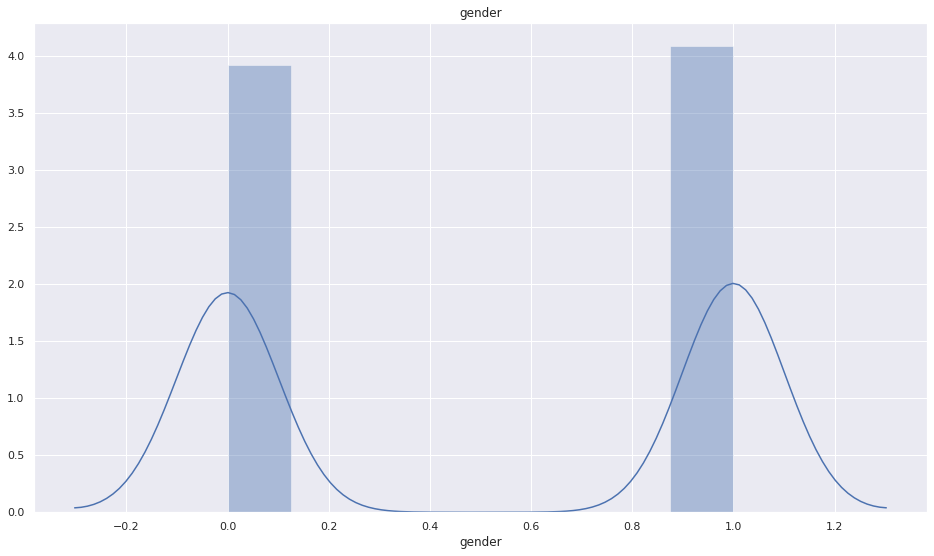

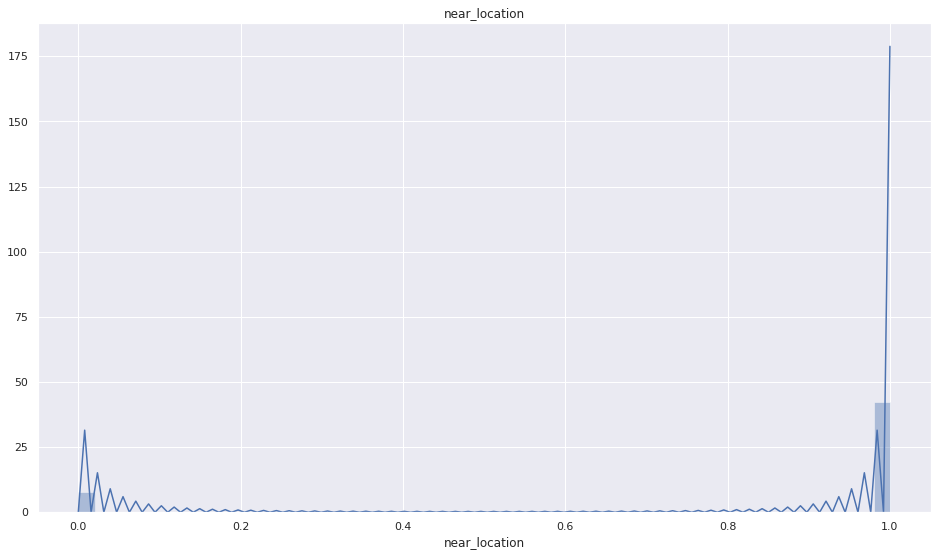

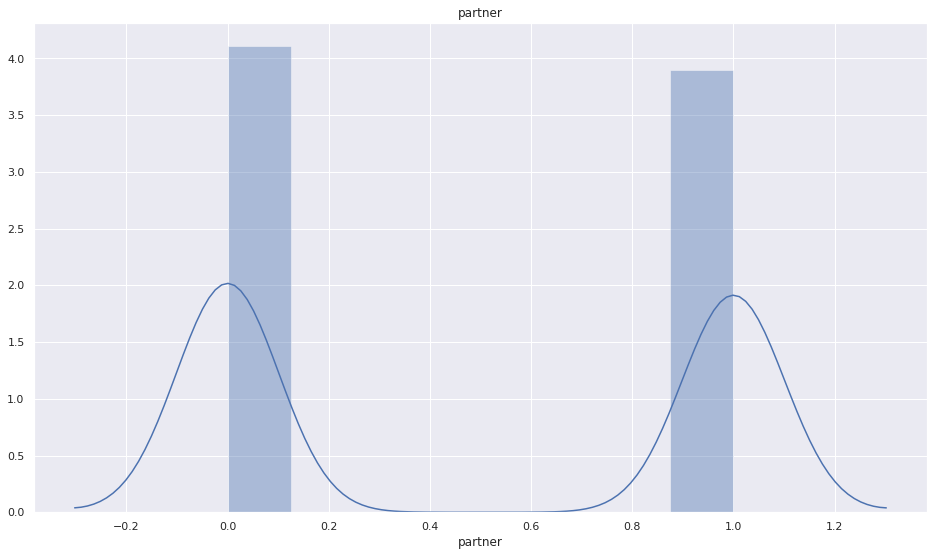

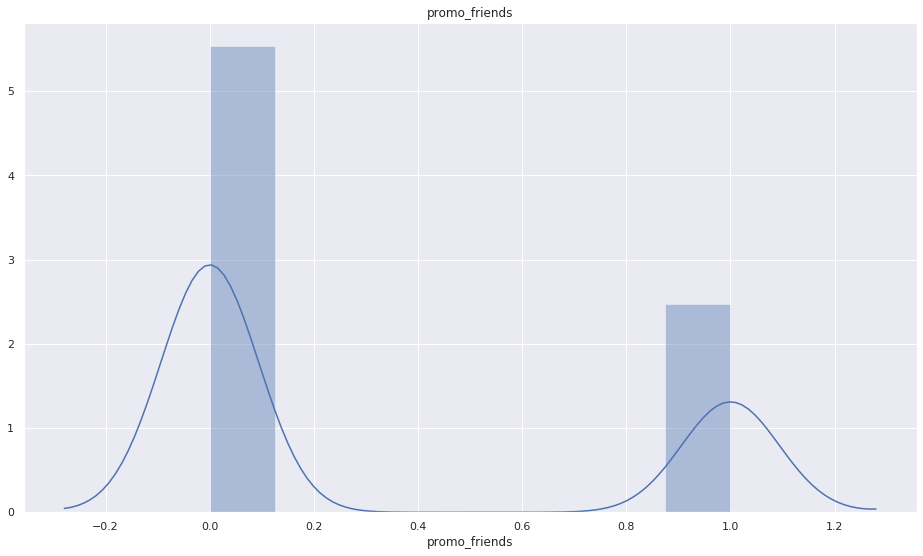

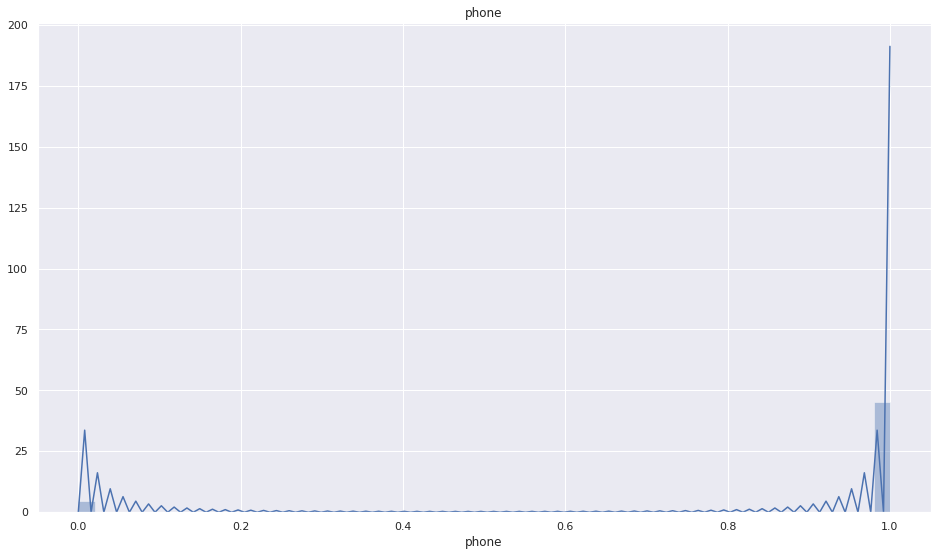

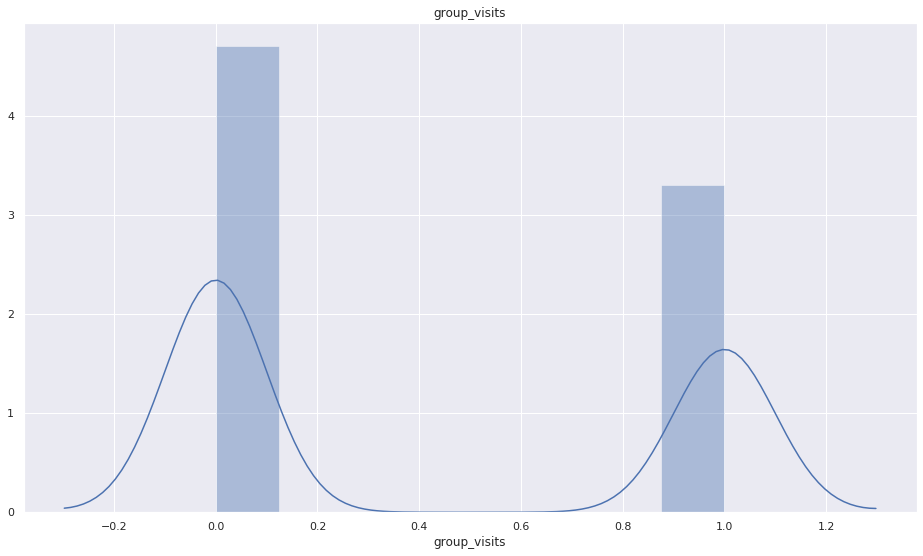

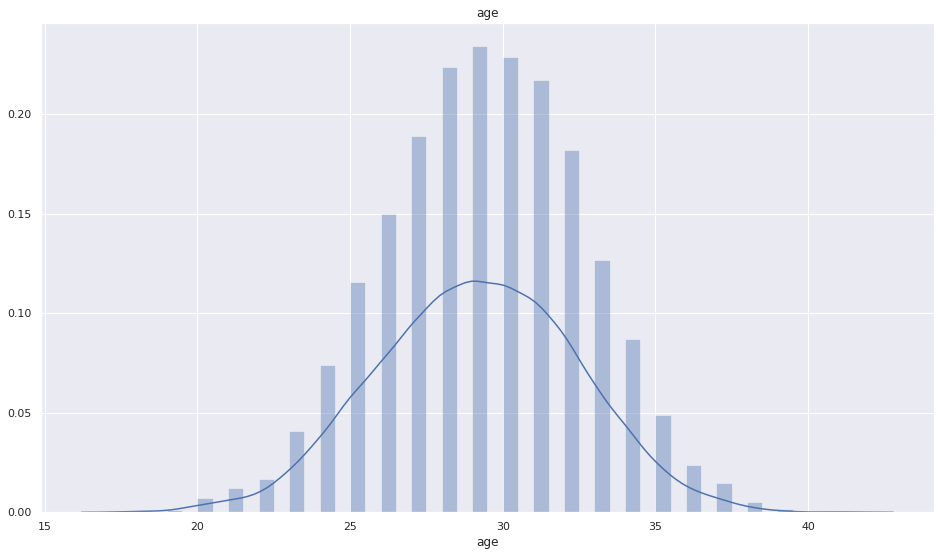

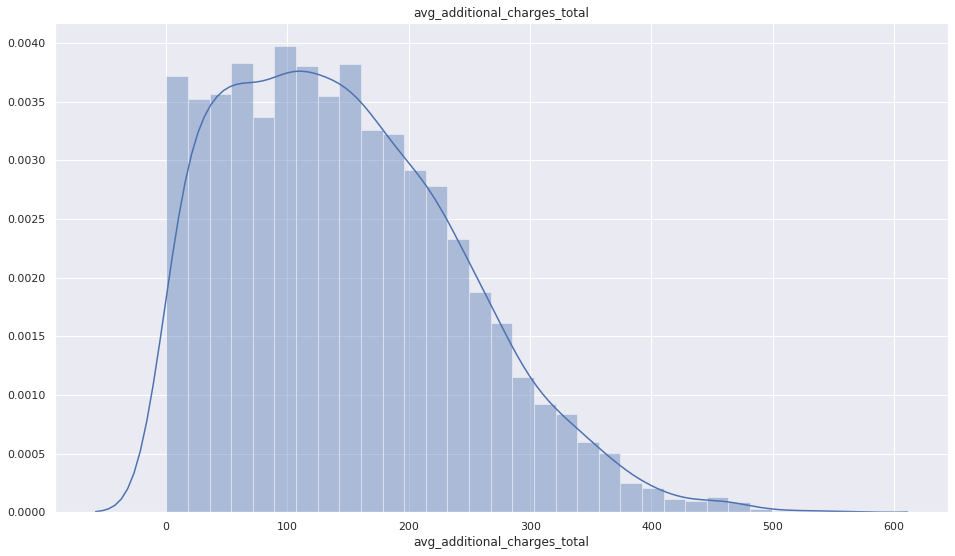

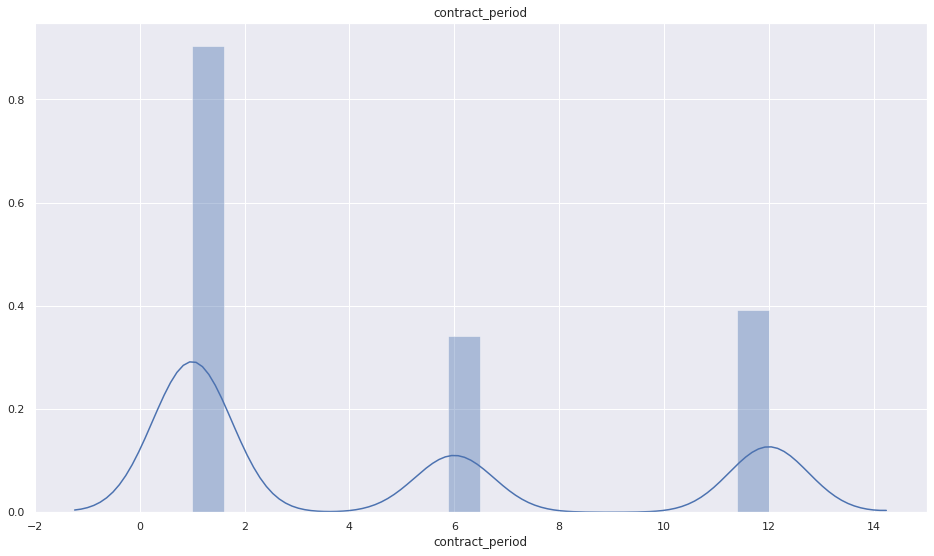

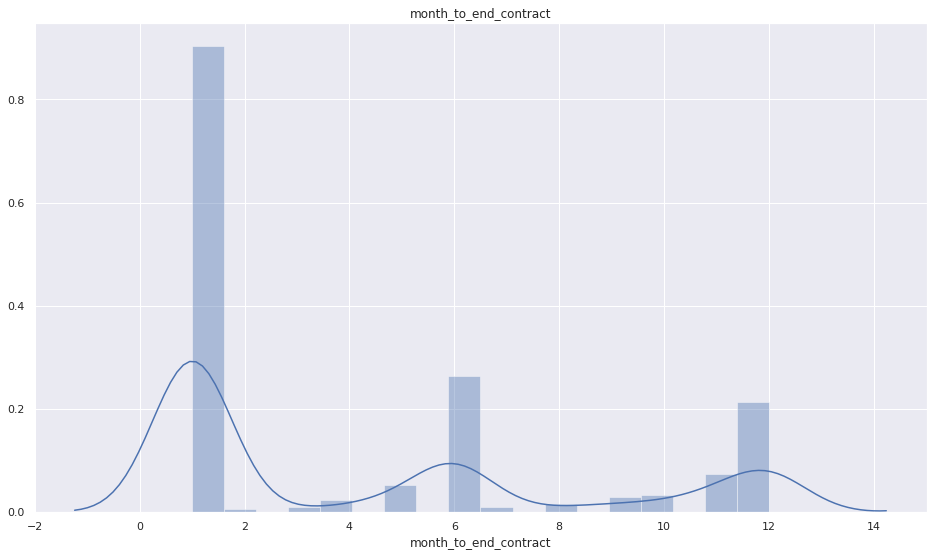

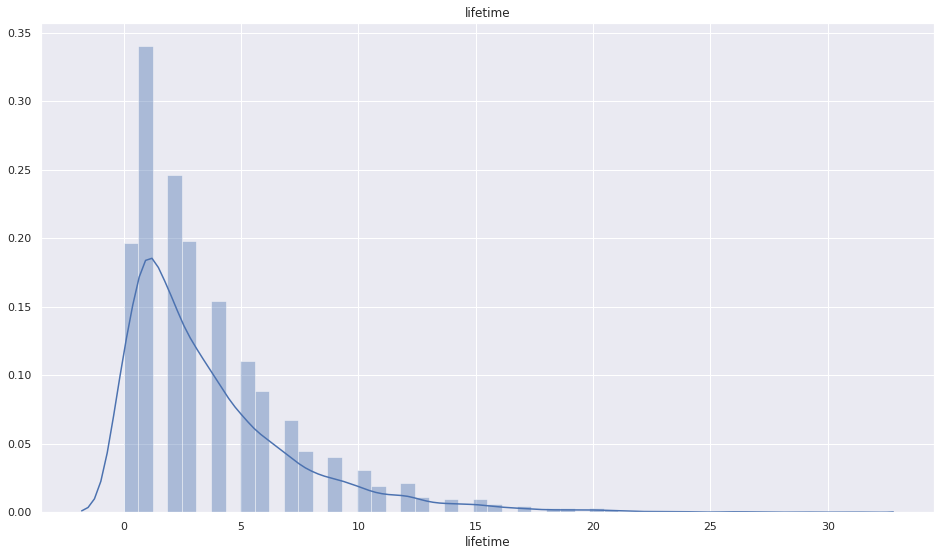

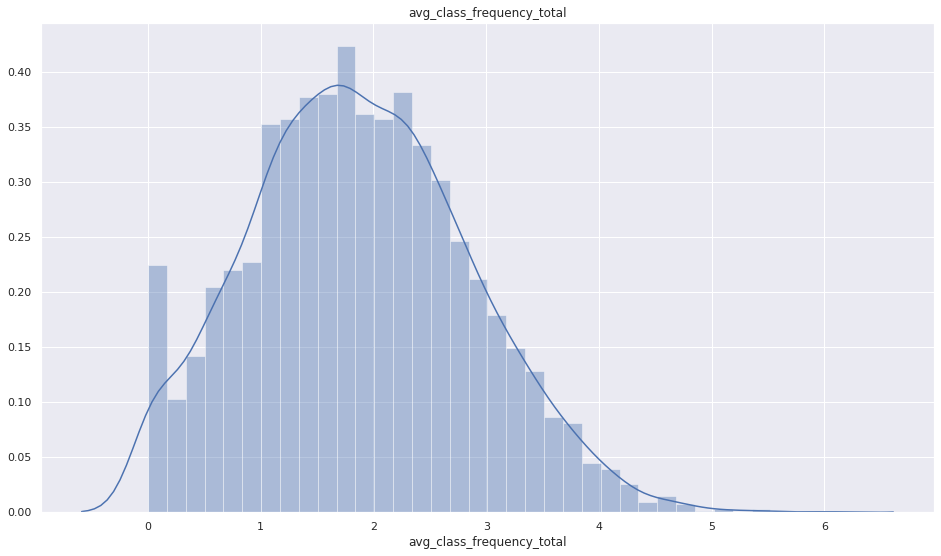

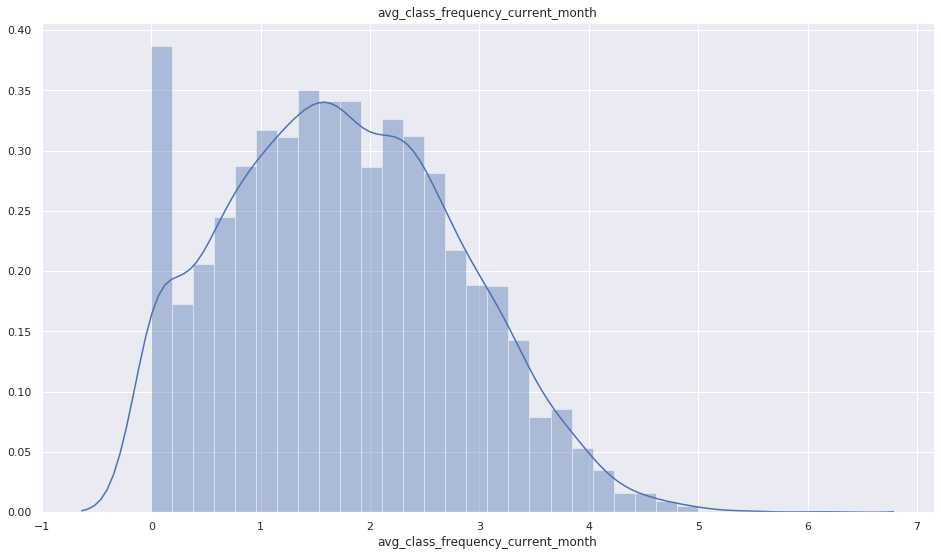

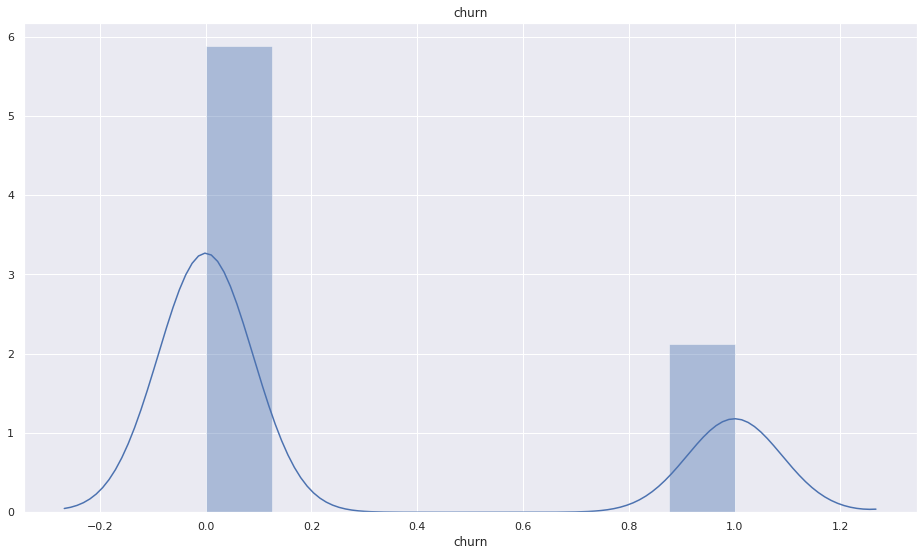

In [10]:
def hist_corr(col):
    df.groupby('churn')[col]
    sns.distplot(df[col])
    plt.title(col)
    plt.show();
    
for column in df.columns:
    hist_corr(column)

Пол не влияет на отток, одинаково уходят как мужчины, так и женщины. Покидают преимущественно те, кто проживает не рядом и у кого нет партнерских отношений с центром. Кроме того клиенты без друзей и не ходящие на групповые занятие, так же больше подвержены оттоку.

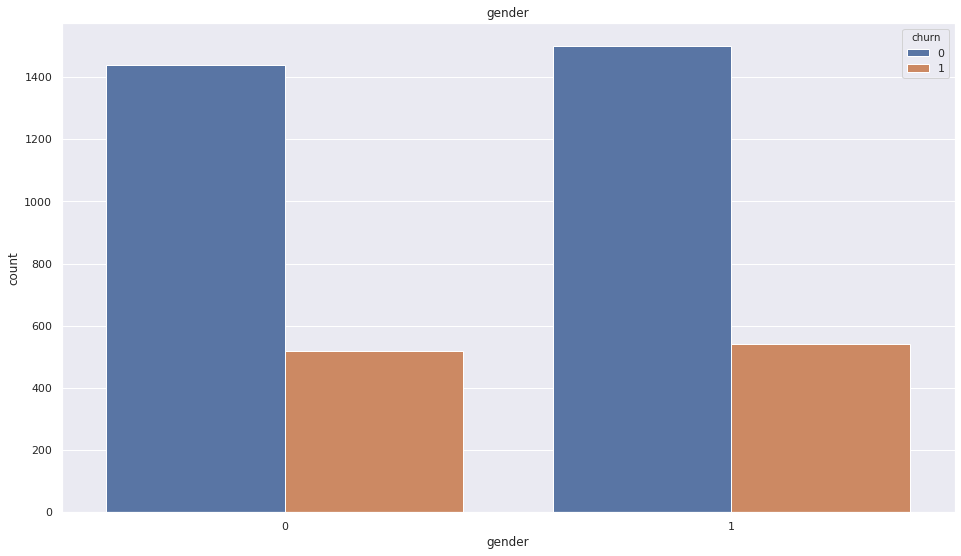

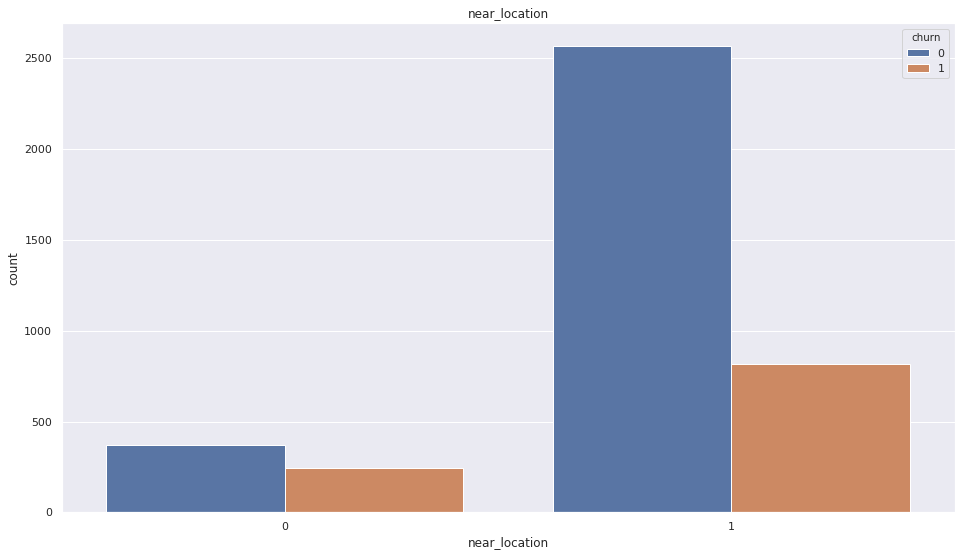

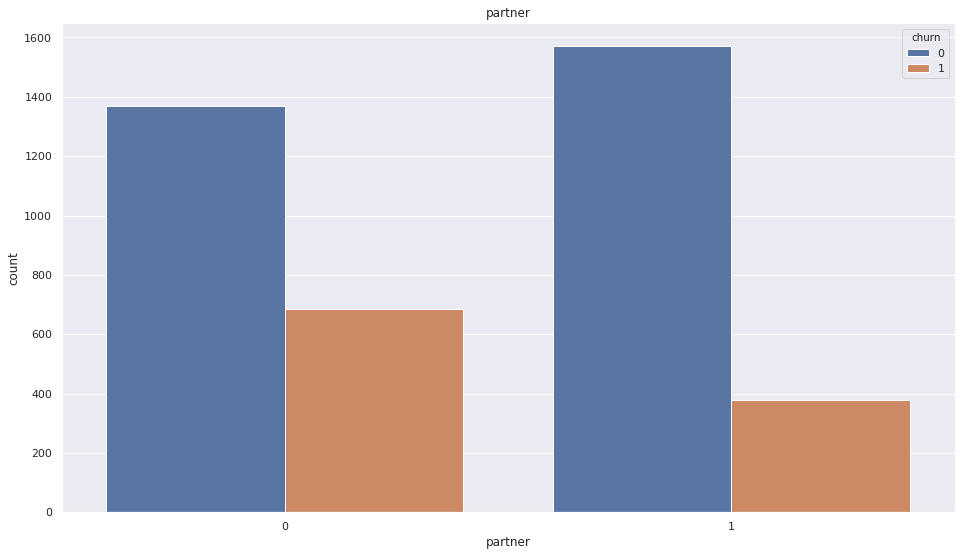

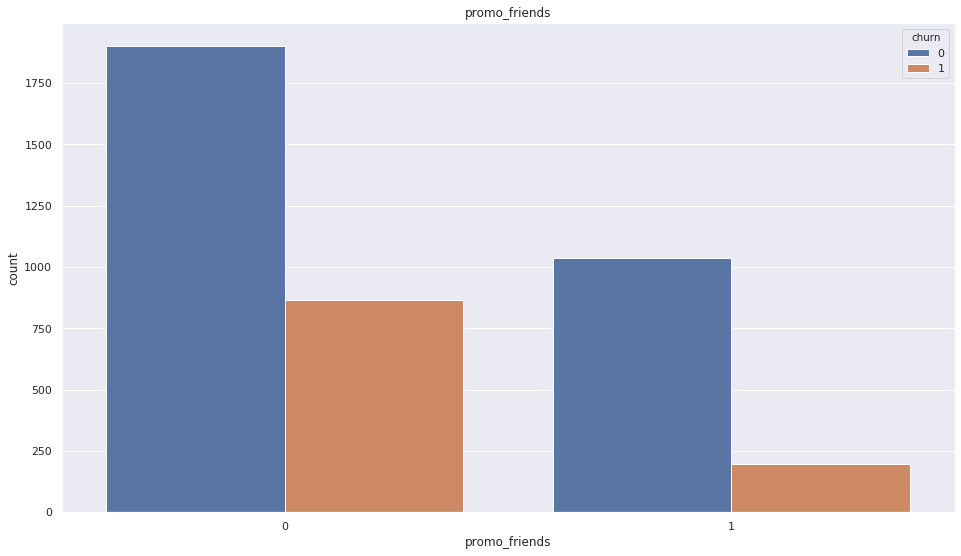

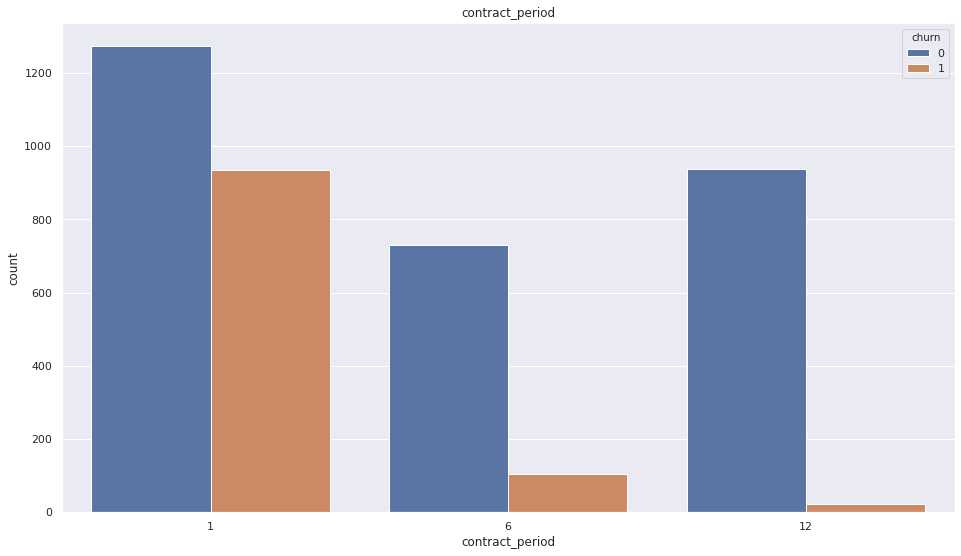

In [11]:
def hist_comp(col):
    sns.countplot(x = df[col], hue='churn', data=df)
    plt.title(col)
    plt.show();
    
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    hist_comp(column)

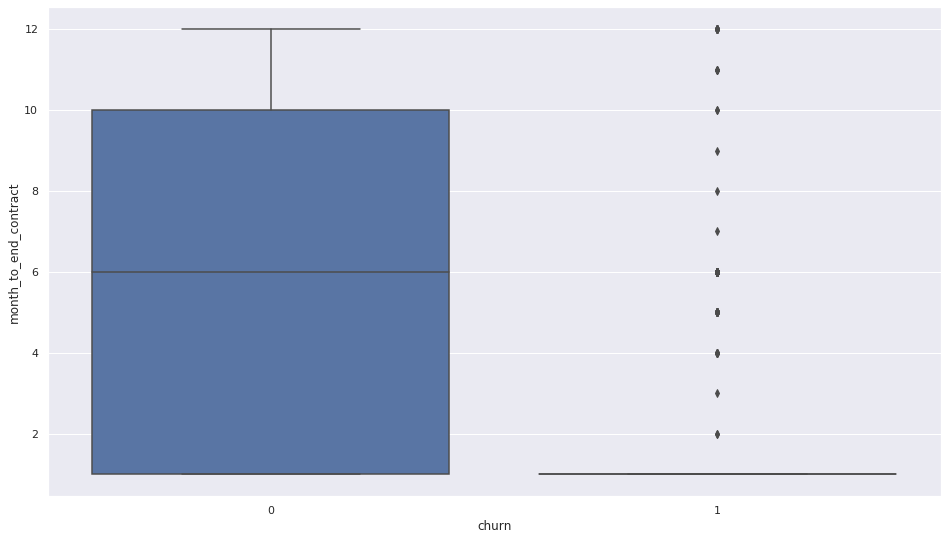

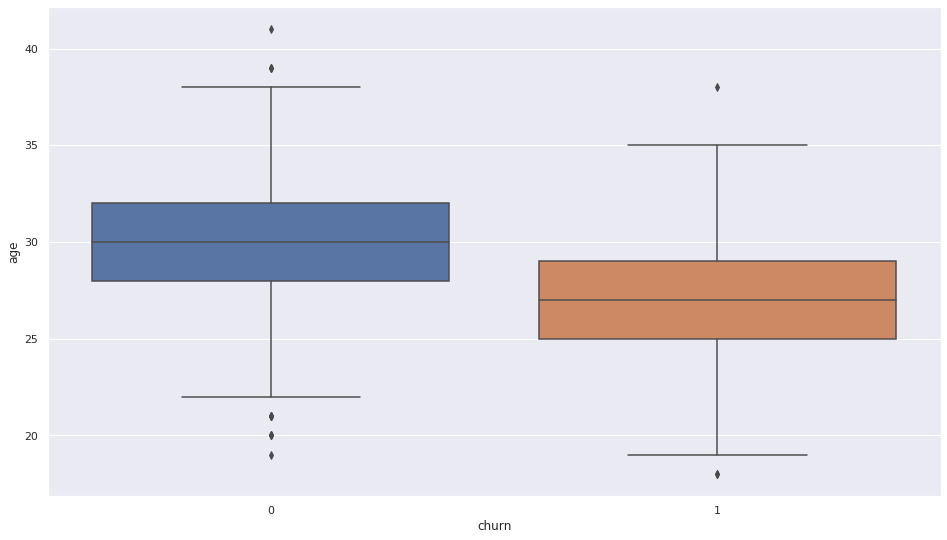

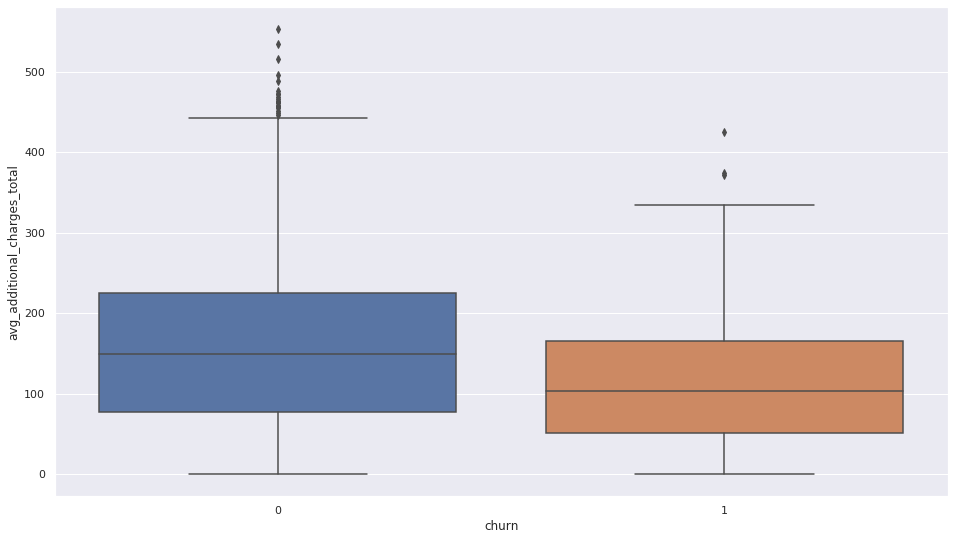

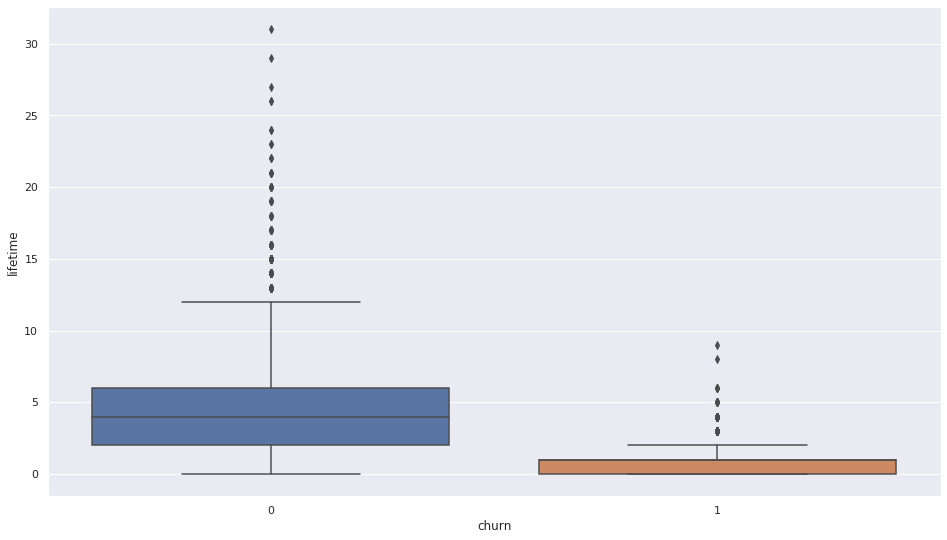

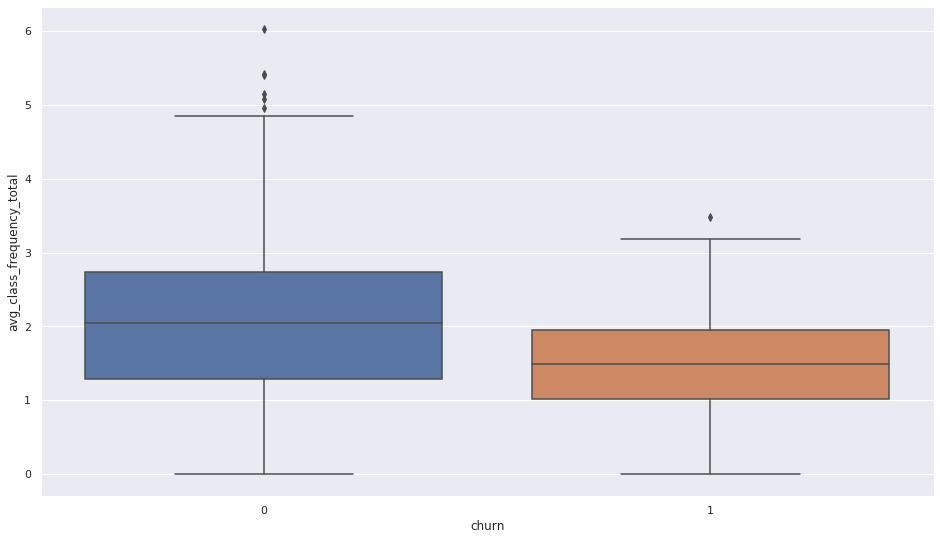

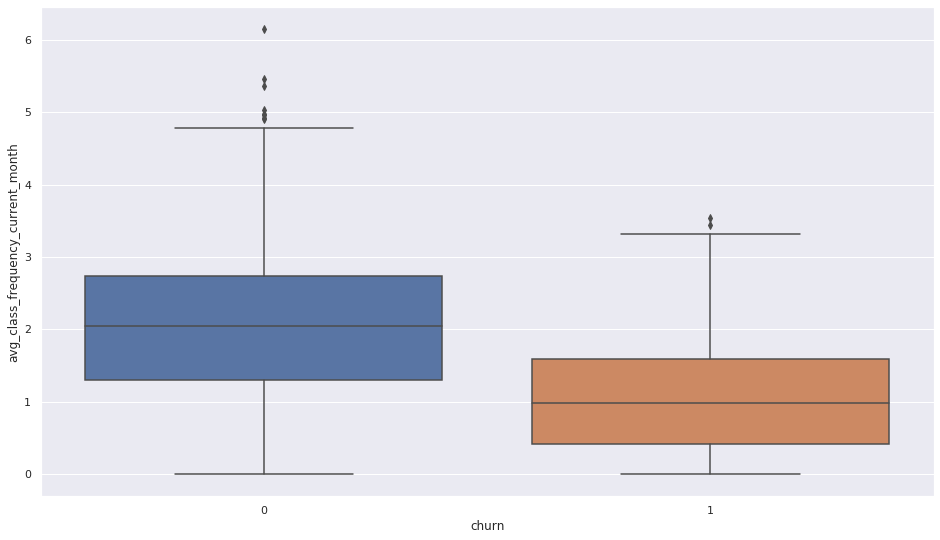

In [12]:
def plot_comp(col):
    sns.boxplot(x = 'churn', y = df[col], data = df)
    plt.show()
    
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime',\
               'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plot_comp(column)

По всем количественным признакам клиенты, которые остались имеют преимущество. Особенно выделается такой признак как длительность абонемента, с долгими абонементами уходят в отток меньше клиентов, кроме того чем дольшедо конца абонемента, тем меньше вероятность что клиент уйдет. Так же, выделяется срок жизни клиента, чем дольше клиент с нами, тем он лояльнее. Не замечено ни одного клиента, который покинул бы нас после 10 месяцев посещений.

<a id='step_24'></a>
### 2.4 Матрица корелляций:

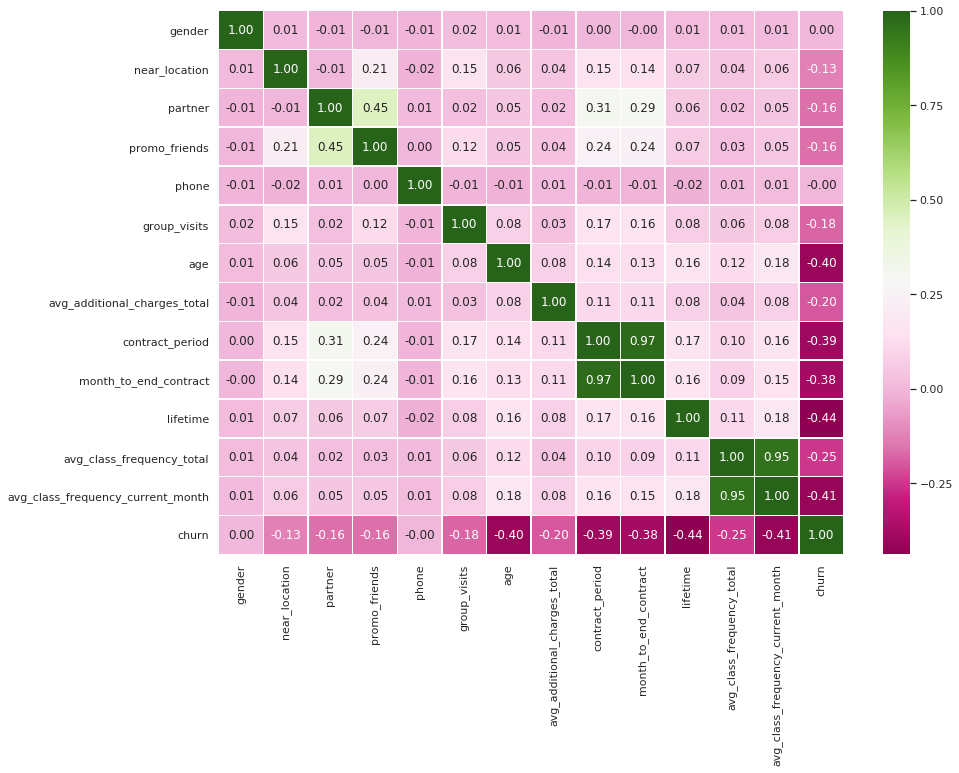

In [13]:
cm = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5, cmap="PiYG")
plt.show();

Наиболее сильные зависимые пары  у сроков абонемента (contract_period - month_to_end_contract) и посещений (avg_class_frequency_current_month - avg_class_frequency_total). Есть так же средняя зависимость между партнерской программой и акцией "приведи друга" (partners - promo_friends).

### Вывод

Самые сильновлияющие на отток признаки - срок абонемента и время с момента первого обращения.

<a id='step_3'></a>
## 3. Модель прогнозирования оттока:

In [14]:
X = df.drop('churn', axis = 1)
y = df['churn']

<a id='step_31'></a>
### 3.1 Логистическая регрессия:

Можно использовать параметр stratify = y в функции train_test_split( ), где y – соответствующая целевая переменная. Данные разделятся на два кластера (наблюдения класса 0 и наблюдения класса 1), и в валидационную выборку попадут по 20% наблюдений из каждого кластера:
    
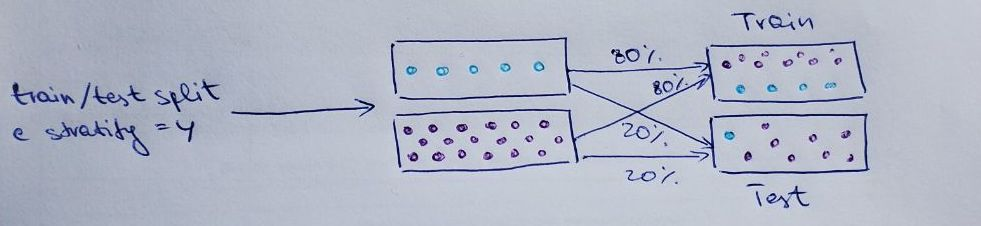
    
То есть, если соотношение классов в оригинальной выборке было 2:5, то в обучающей и валидационной выборках оно сохранится таким же. Такой подход в чем-то решает проблему несбалансированных классов.
</div>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85


<a id='step_32'></a>
### 3.2 Случайный лес:

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

StandardScaler(copy=True, with_mean=True, with_std=True)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.81
F1: 0.82


### Вывод

Логистическая регрессия немного лучше по каждой из метрик, чем случайный лес. Доля правильных ответов равна 93%, точность прогноза 86%, полнота 83%, а баланс метрик 85%.

<a id='step_4'></a>
## 4. Кластеризация клиентов:

In [19]:
# Провел стандартизацию всех параметров
df_sс = df.drop(['churn'], axis=1)
df_columns_list = df_sс.columns

# Преобразовал набор данных
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

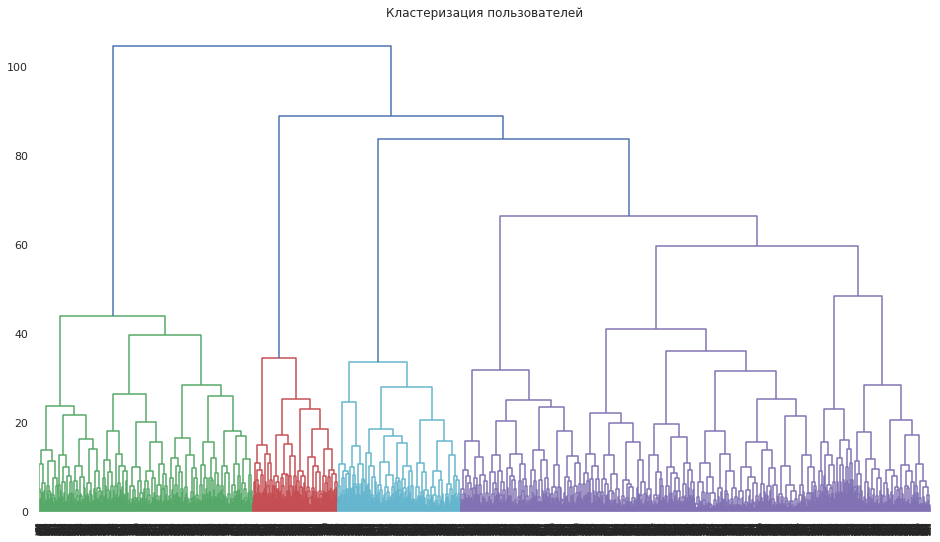

In [20]:
# Сформировал таблицу связок
linked = linkage(df_sс, method = 'ward')

# Дендограмма
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show();

Возьмем порог линии чуть выше 60, выделим 5 кластеров.

In [21]:
#fix_1
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(df_sс)
df['cluster'] = labels

In [22]:
df.cluster.value_counts()

3    1262
0    1011
4    837 
2    505 
1    385 
Name: cluster, dtype: int64

In [23]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.71,143.96,135.46,131.62,161.72
contract_period,10.88,4.79,2.35,1.95,2.67
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


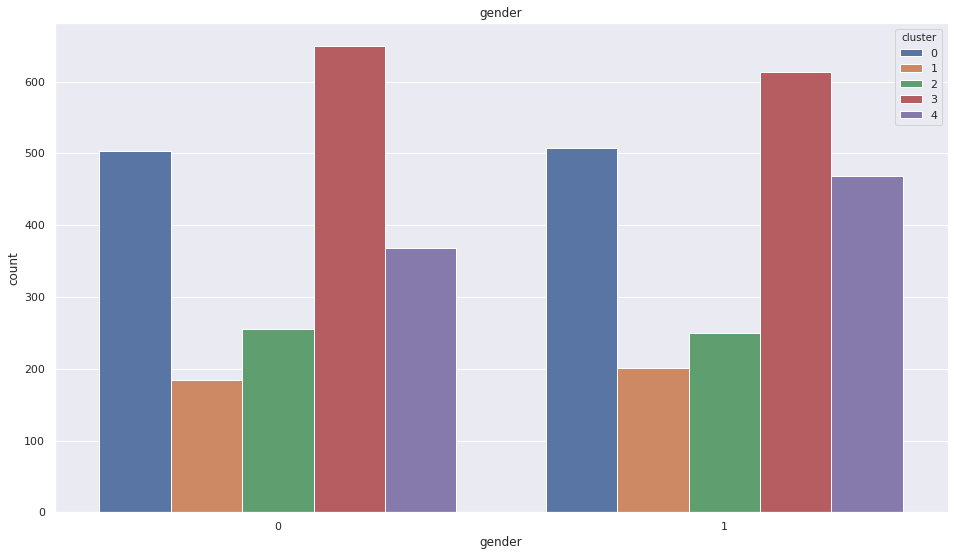

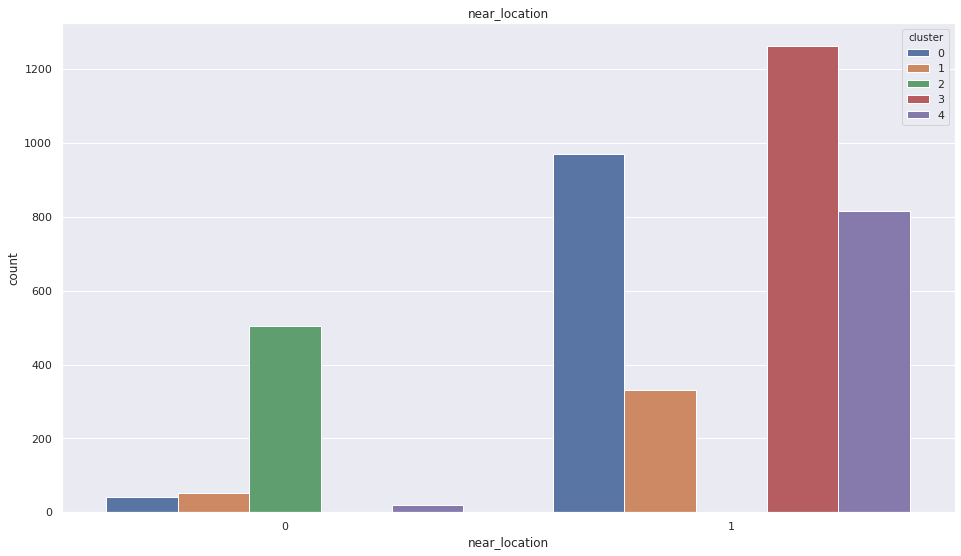

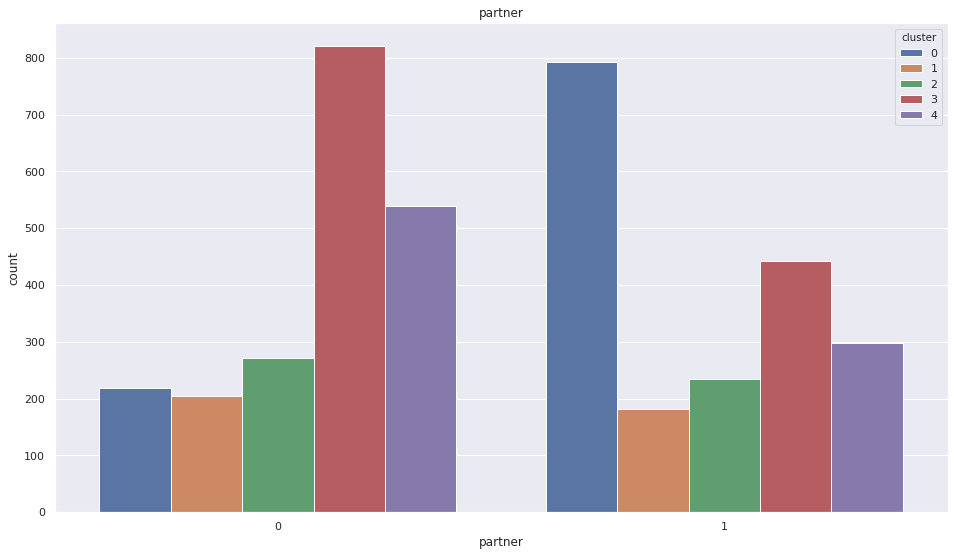

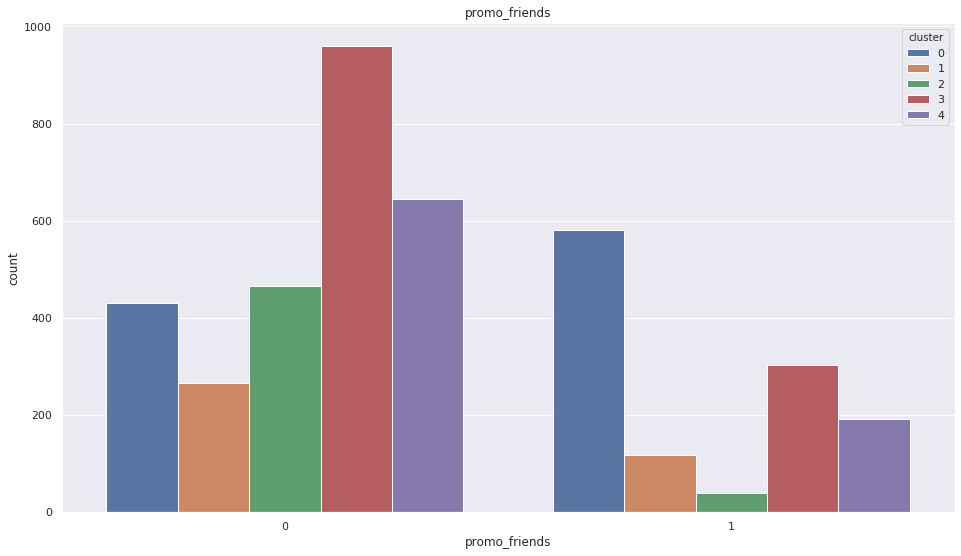

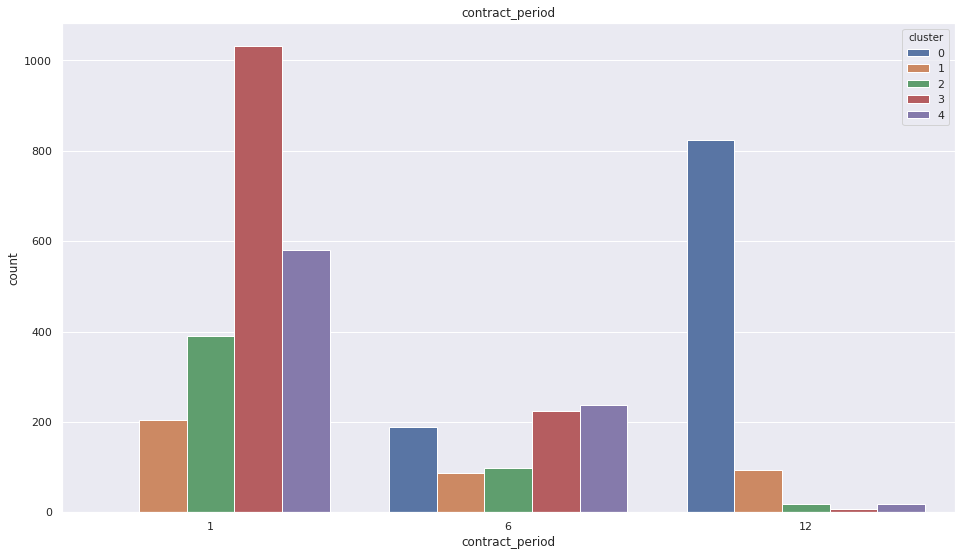

In [24]:
def cluster_comp(col):
    sns.countplot(x = df[col], hue='cluster', data=df)
    plt.title(col)
    plt.show();
    
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    cluster_comp(column)

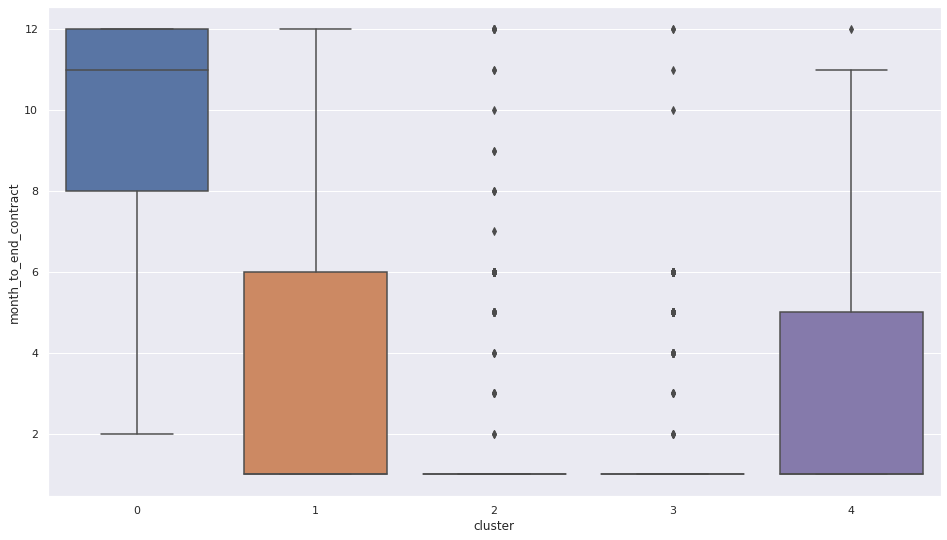

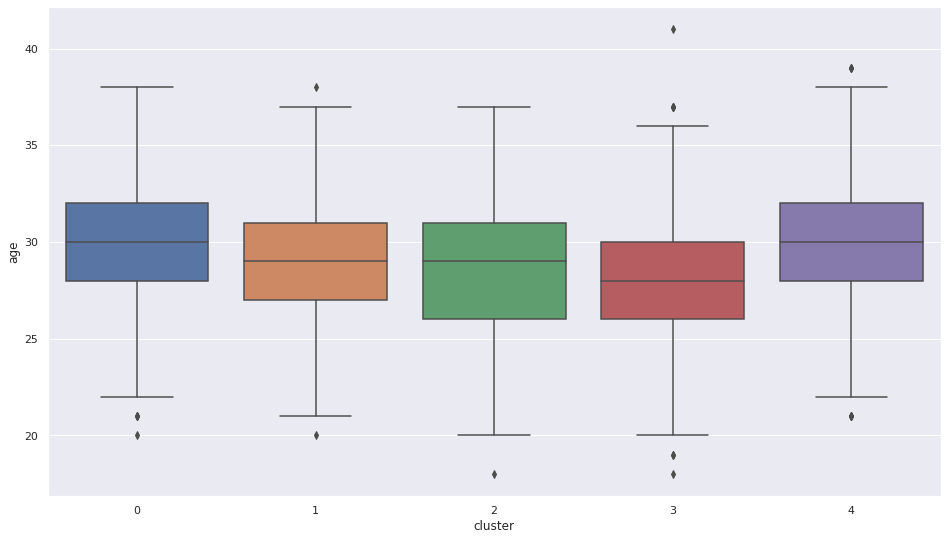

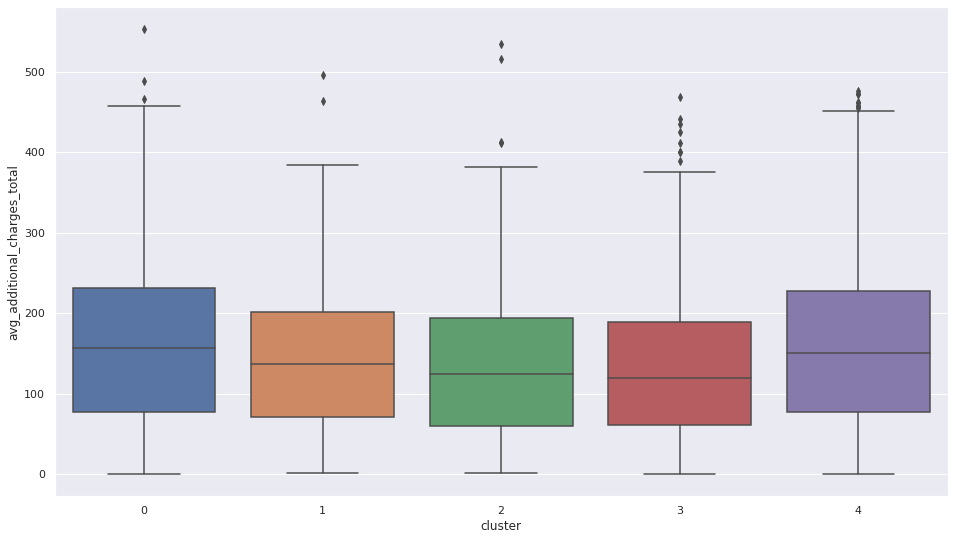

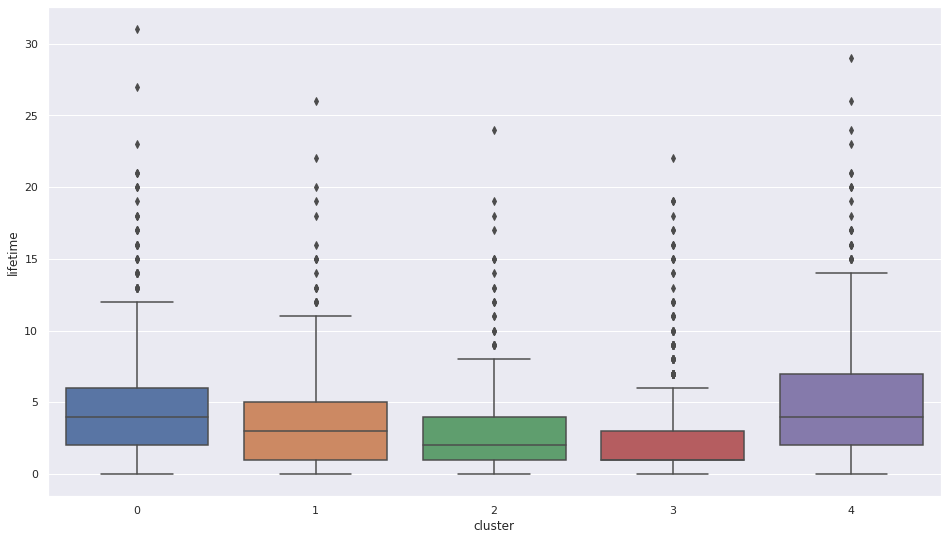

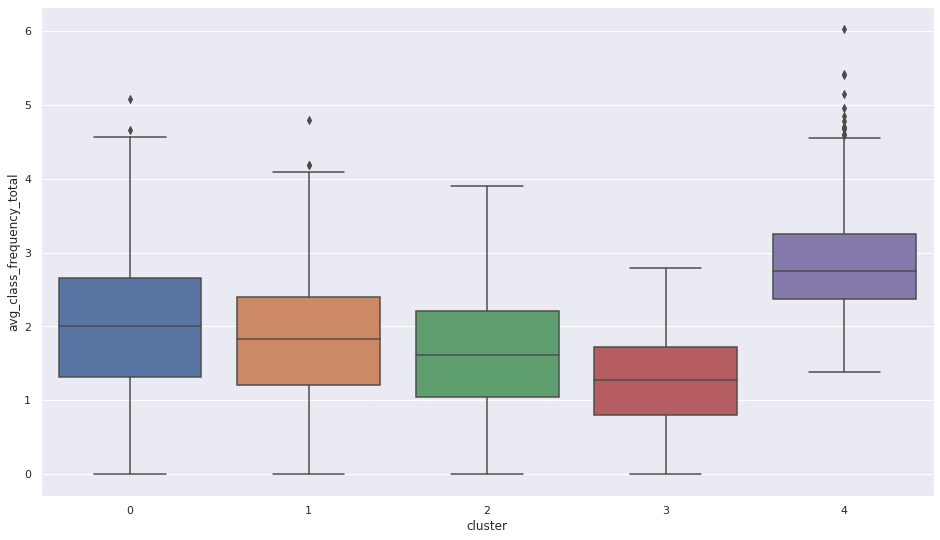

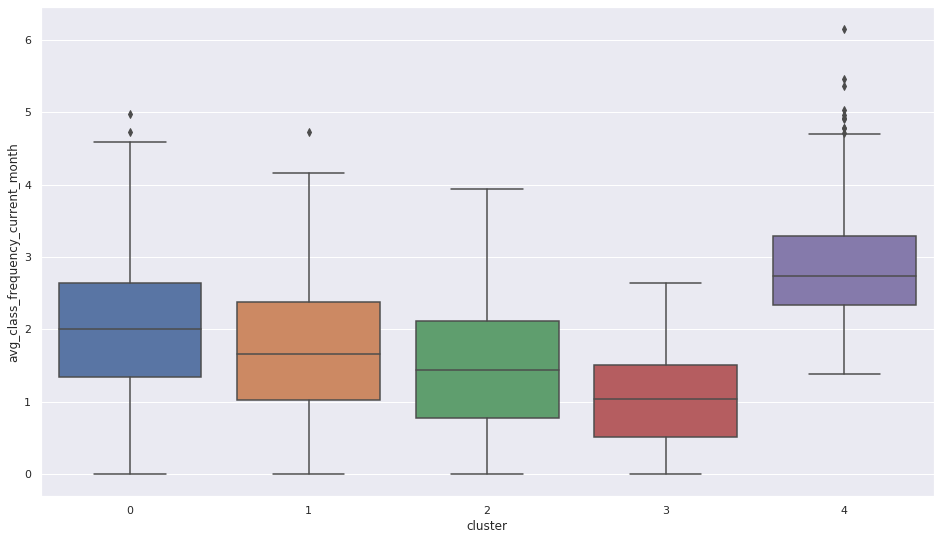

In [25]:
def cluster_plot(col):
    sns.boxplot(x = 'cluster', y = df[col], data = df)
    plt.show()
    
for column in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    cluster_plot(column)

### Вывод

<b>Кластер c оттоком ~3%</b>
* Самая большая длительность текущего абонемента, почти более ~11 месяцев. Пришли преимущественно по партнерской программе (78%), каждый второй в рамках "приведи-друга".
* Эти клиенты чаще других посещают групповые занятия (54%) и в среднем тренеруются 2 раза в неделю. С этих клиентов центр имеет большее всего дополнительных доходов.

<b>Кластер c оттоком ~7%</b>
* Так же много клиентов находятся рядом с центром, и у многих имеются партнерские отношения с фитнесом, доля пришедших с друзьями - каждый четвертый.
* Около половины посещало групповые занятия. Доп заработок фитнес центра, как и от первого кластера, значительный, по сравнению с прочими.

<b>Кластер c оттоком ~27%</b>
* Клиенты не оставляющие свой номер телефона. Находятся недалеко от фитнес-центра, почти половина имеют партнерские отношения и около трети пришли от друзей. Длительность абонемента, срок до конца и "срок жизни" примерно одинаковые, около 3-4.

* По остальным параметрам клиенты из группы особо не выделяются, можно сказать что в общем, они посещают фитнес реже чем клиенты из других групп.

<b>Кластер c оттоком ~44%</b>
* Почти никого нет рядом с фитнес-центром, абонемент в среднем 2.5 месяца, и слабая посещаемость групповых занятий. Всего 8% пришли от друзей.

<b>Кластер c оттоком ~51%</b>
* Имеют самые короткие абонементы (2 месяца) и срок жизни.
* Особенно четко выделяются на фоне прочих тем, что редко посещают центр и приносят самый низкий доп. доход.

<a id='step_5'></a>
## 5. Общий вывод:

Особенно пристальное внимание нужно уделять продолжительности абонемента. Чем меньше продолжительность абонемента, тем больше вероятность, что клиент перестанет появляться. Наиболее безопасная длительность - 6 месяцев. Необходимо стимулировать клиентов, предлагать бонусы, скидки и т.п., чтобы они оформляли абонемент на 6 месяцев.

Отдельно следует обращать внимание на посещаемость, как в целом, так и на посещение групповых занятий. Чем реже клиент посещает фитнес-центр, тем более вероятно что он уйдет.
Не все ходят на групповые занятия, но в кластерах где эта доля особенно низка, наблюдается больший процент оттока. Таким образом, для удержания клиентов можно привлекать их на тренировки и групповые занятия бесплатными пробными занятиями, мастер-классами и т.п.